In [1]:
from PIL import Image

In [2]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    pixels = img.load()
    return img, pixels

In [4]:
def downsample_max(img, new_w, new_h):
    w, h = img.size
    pixels = img.load()
    out = Image.new("RGB", (new_w, new_h))
    out_pix = out.load()
    #scale
    scale_x = w / new_w
    scale_y = h / new_h
    
    for ny in range(new_h):
        for nx in range(new_w):
            x0 = int(nx * scale_x)
            y0 = int(ny * scale_y)
            x1 = int((nx + 1) * scale_x)
            y1 = int((ny + 1) * scale_y)
            
            r, g, b = 0, 0, 0
            max_val = [0, 0, 0]
            for yy in range(y0, min(y1, h)):
                for xx in range(x0, min(x1, w)):
                    pr, pg, pb = pixels[xx, yy]
                    max_val[0] = max(max_val[0], pr)
                    max_val[1] = max(max_val[1], pg)
                    max_val[2] = max(max_val[2], pb)
            out_pix[nx, ny] = tuple(max_val)
    return out

In [5]:
def downsample_mean(img, new_w, new_h):
    w, h = img.size
    pixels = img.load()
    out = Image.new("RGB", (new_w, new_h))
    out_pix = out.load()
    #scale
    scale_x = w / new_w
    scale_y = h / new_h
    
    for ny in range(new_h):
        for nx in range(new_w):
            x0 = int(nx * scale_x)
            y0 = int(ny * scale_y)
            x1 = int((nx + 1) * scale_x)
            y1 = int((ny + 1) * scale_y)
            
            
            r, g, b, cnt = 0, 0, 0, 0
            for yy in range(y0, min(y1, h)):
                for xx in range(x0, min(x1, w)):
                    pr, pg, pb = pixels[xx, yy]
                    r += pr; g += pg; b += pb
                    cnt += 1
            if cnt > 0:
                r //= cnt; g //= cnt; b //= cnt
            out_pix[nx, ny] = (r, g, b)
    return out

In [6]:
def downsample_median(img, new_w, new_h):
    w, h = img.size
    pixels = img.load()
    out = Image.new("RGB", (new_w, new_h))
    out_pix = out.load()
    
    #scale
    scale_x = w / new_w
    scale_y = h / new_h
    
    #pixel loop
    for ny in range(new_h):
        for nx in range(new_w):
            x0 = int(nx * scale_x)
            y0 = int(ny * scale_y)
            x1 = int((nx + 1) * scale_x)
            y1 = int((ny + 1) * scale_y)

            
            rlist, glist, blist = [], [], []
            for yy in range(y0, min(y1, h)):
                for xx in range(x0, min(x1, w)):
                    pr, pg, pb = pixels[xx, yy]
                    rlist.append(pr)
                    glist.append(pg)
                    blist.append(pb)
                    
            if rlist:
                rlist.sort(); glist.sort(); blist.sort()
                mid = len(rlist)//2
                out_pix[nx, ny] = (rlist[mid], glist[mid], blist[mid])
    return out

In [7]:
def upsample_nearest(img, new_w, new_h):
    w, h = img.size
    pixels = img.load()
    out = Image.new("RGB", (new_w, new_h))
    out_pix = out.load()
    
    #scale
    scale_x = w / new_w
    scale_y = h / new_h
    
    
    for ny in range(new_h):
        for nx in range(new_w):
            src_x = int(nx * scale_x)
            src_y = int(ny * scale_y)
            out_pix[nx, ny] = pixels[min(src_x, w-1), min(src_y, h-1)]
    return out

In [8]:
def upsample_bilinear(img, new_w, new_h):
    w, h = img.size
    pixels = img.load()
    out = Image.new("RGB", (new_w, new_h))
    out_pix = out.load()
    
    #scale
    scale_x = w / new_w
    scale_y = h / new_h
    
    
    for ny in range(new_h):
        for nx in range(new_w):
            gx = nx * scale_x
            gy = ny * scale_y
            x0, y0 = int(gx), int(gy)
            x1, y1 = min(x0+1, w-1), min(y0+1, h-1)
            dx, dy = gx - x0, gy - y0
            
            
            c00 = pixels[x0, y0]
            c10 = pixels[x1, y0]
            c01 = pixels[x0, y1]
            c11 = pixels[x1, y1]
            
            
            r = int((c00[0]*(1-dx)*(1-dy) + c10[0]*dx*(1-dy) + c01[0]*(1-dx)*dy + c11[0]*dx*dy))
            g = int((c00[1]*(1-dx)*(1-dy) + c10[1]*dx*(1-dy) + c01[1]*(1-dx)*dy + c11[1]*dx*dy))
            b = int((c00[2]*(1-dx)*(1-dy) + c10[2]*dx*(1-dy) + c01[2]*(1-dx)*dy + c11[2]*dx*dy))
            out_pix[nx, ny] = (r, g, b)
            
    return out

In [9]:
def cubic_weight(t):
    a = -0.5 # Catmull-Rom spline
    t = abs(t)
    if t <= 1:
        return (a+2)*t**3 - (a+3)*t**2 + 1
    elif t < 2:
        return a*t**3 - 5*a*t**2 + 8*a*t - 4*a
    return 0

In [10]:
def upsample_bicubic(img, new_w, new_h):
    w, h = img.size
    pixels = img.load()
    out = Image.new("RGB", (new_w, new_h))
    out_pix = out.load()
    
    
    scale_x = w / new_w
    scale_y = h / new_h
    
    
    for ny in range(new_h):
        for nx in range(new_w):
            gx = nx * scale_x
            gy = ny * scale_y
            x_int, y_int = int(gx), int(gy)
            dx, dy = gx - x_int, gy - y_int
            
            
            r, g, b = 0.0, 0.0, 0.0
            total_w = 0.0
            for m in range(-1, 3):
                for n in range(-1, 3):
                    xm = min(max(x_int + m, 0), w-1)
                    yn = min(max(y_int + n, 0), h-1)
                    wm = cubic_weight(m - dx)
                    wn = cubic_weight(dy - n)
                    wght = wm * wn
                    pr, pg, pb = pixels[xm, yn]
                    r += pr * wght
                    g += pg * wght
                    b += pb * wght
                    total_w += wght
            if total_w != 0:
                r /= total_w; g /= total_w; b /= total_w
                out_pix[nx, ny] = (int(r), int(g), int(b))
    return out

In [11]:
#main  program
img, _ = load_image("gambar.jpg")
#img, new widt
small_max = downsample_max(img, 100, 100)
small_mean = downsample_mean(img, 100, 100)
small_med = downsample_median(img, 100, 100)
#
up_near = upsample_nearest(small_mean, 300, 300)
up_bilin = upsample_bilinear(small_mean, 300, 300)
up_bicub = upsample_bicubic(small_mean, 300, 300)
#


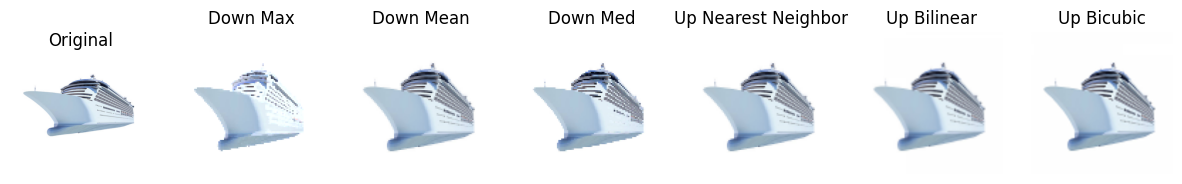

In [15]:
#plot using matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 7, figsize=(15,5))
axs[0].imshow(img); axs[0].set_title("Original"); axs[0].axis("off")
axs[1].imshow(small_max); axs[1].set_title("Down Max"); axs[1].axis("off")
axs[2].imshow(small_mean); axs[2].set_title("Down Mean"); axs[2].axis("off")
axs[3].imshow(small_med); axs[3].set_title("Down Med"); axs[3].axis("off")
axs[4].imshow(up_near); axs[4].set_title("Up Nearest Neighbor"); axs[4].axis("off")
axs[5].imshow(up_bilin); axs[5].set_title("Up Bilinear"); axs[5].axis("off")
axs[6].imshow(up_bicub); axs[6].set_title("Up Bicubic"); axs[6].axis("off")
plt.show()